In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn

# 1. Prepare Data

Lets make an example using linear regression, which has the formula of Y = a + bX. In the code below the weight will be b and the bias will be a.

## 1.1 Generate Data

In [2]:
# Create known parameter
weight = 0.7
bias = 0.3

In [3]:
# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

## 1.2 Train-Test Split

We always want to generate three datasets: Training dataset to train the model, validation dataset to validate whether the model does a good job and the test dataset to test the model on unseen data.

In [4]:
# Create a train-test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [5]:
def plot_predictions(train_data=X_train, train_labels=y_train,
                     test_data=X_test, test_labels=y_test,
                     predictions=None):

    """ Plots training and test data and compares predictions """

    plt.figure(figsize=(10,7))
    # Plot training data
    plt.scatter(train_data, train_labels, c='darkblue', s=4, label='Training Data')
    # Plot test data
    plt.scatter(test_data, test_labels, c='green', s=4, label='Test Data')

    if predictions is not None:
        # Plot predictions if they exist
        plt.scatter(test_data, predictions, c='red', s=4, label='Predictions')

    plt.legend(prop={'size': 12})

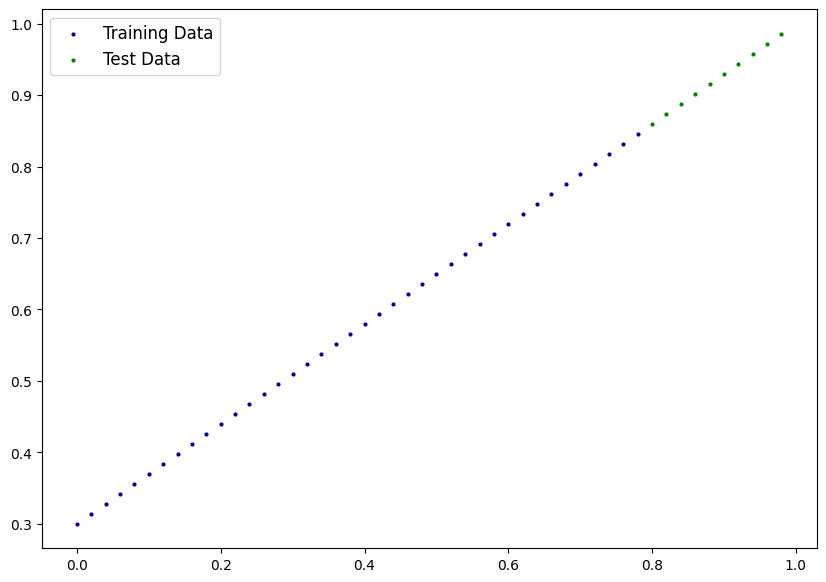

In [6]:
plot_predictions()

## 1.3 Build Model

Y = a + bX

What our model is doing is it will start with random values for weights and bias, learns from the training data and adjusts the parameters weights and bias. The model is doing it through gradient descent and backpropagation. Gradient descent is the reason we have set requires_grad=True for the two parameters.

- nn.Module contains the larger building blocks (layers)
- nn.Parameter contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
- forward() tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
- torch.optim contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data

In [7]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True,
                                                dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True,
                                             dtype=torch.float32))
        
    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x = input data
        return self.weights * x + self.bias # linear regression formula

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [9]:
# Make predictions with model
with torch.inference_mode(): # same as torch.no_grad()
    y_preds = model_0(X_test)

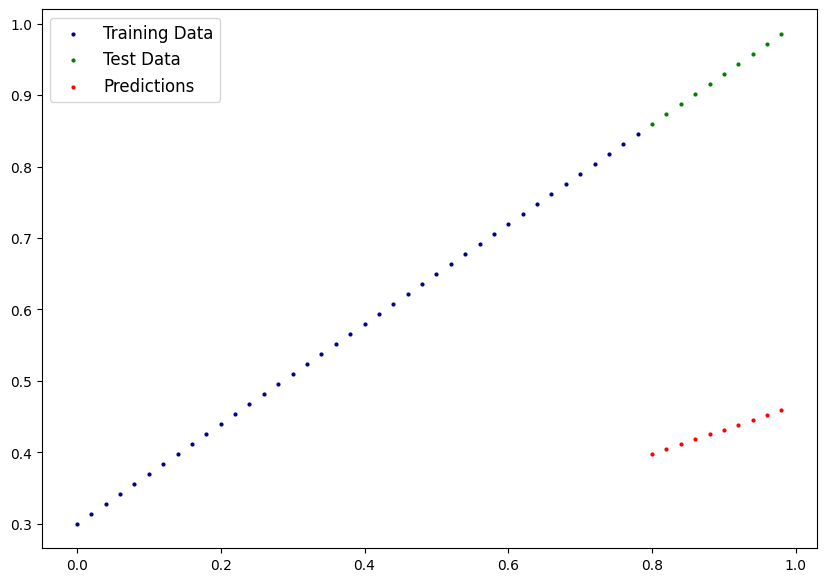

In [10]:
# Plot predictions
plot_predictions(predictions=y_preds)

## 1.4 Train Model

For our model to update its parameters on its own, we'll need to add a few more things to our recipe. And that's a loss function as well as an optimizer.

**Training Loop:**
- Loop through the data
- Forward Pass, which moves data through forward function - also called forward propagation
- Calculate Loos: compare forward pass predictions to ground truth labels
- Optimizer zero grad
- Loss backward: Move backwards through the network to calculate the gradients of each of the parameters which respect to the loss (Backpropagation)
- Optimizer step: Use the optimizer to adjust our models parameters to try and improve the loss (Gradient descent)

In [11]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

c:\Users\lukas\anaconda3\envs\pytorch_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
torch.manual_seed(42)

# Epoch is one loop through the data
epochs = 200

# Track values for experiment
epoch_count = []
loss_values = []
test_loss_values = []

# Loop through the data
for epoch in range(epochs):
    # TRAINING
    # 0. Set model to training mode
    model_0.train() # Turns on gradient tracking
    # 1. Forward pass
    y_pred = model_0(X_train)
    # 2. Calculate Loss
    loss = loss_fn(y_pred, y_train) # input then targets
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Perform Backpropagation on loss with respect to parameters of model
    loss.backward()
    # 5. Step the optimizer - perform gradient descent
    optimizer.step()

    # TESTING / EVALUATION
    model_0.eval() # Turns off gradient tracking
    with torch.inference_mode():
        # 1. Do forward pass
        test_pred = model_0(X_test)
        # 2. Calculate the test loss
        test_loss = loss_fn(test_pred, y_test)

    # Print out whats happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())

Epoch: 0 | Test: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Test: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Test: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Test: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Test: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Test: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Test: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

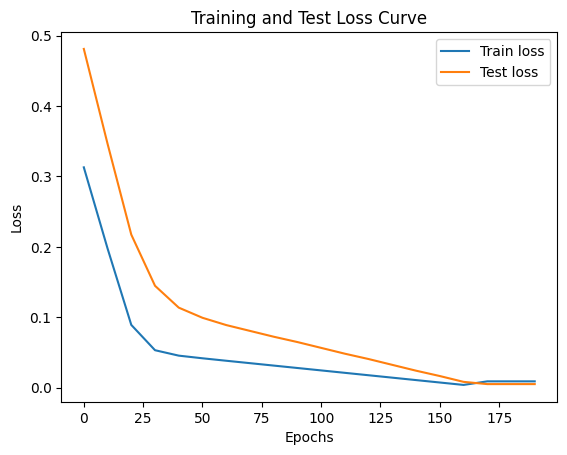

In [13]:
# Plot loss curve
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and Test Loss Curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

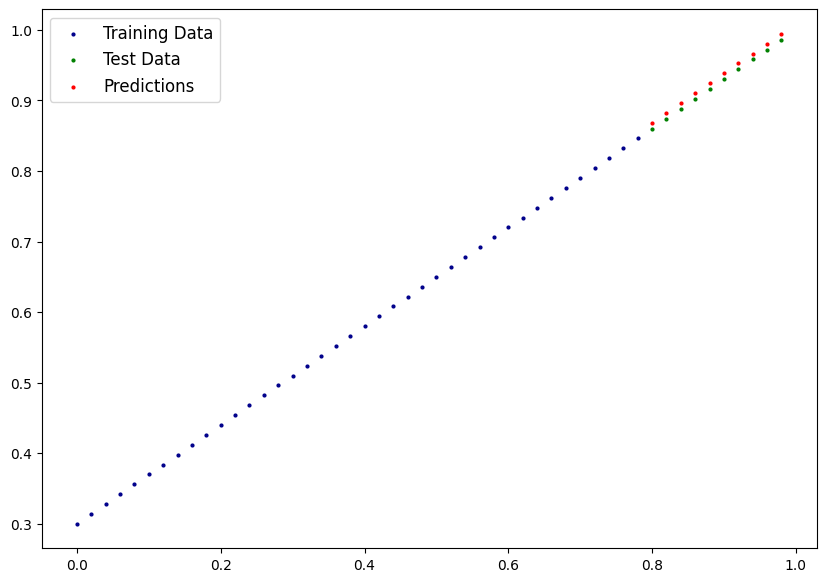

In [14]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

# Plot predictions
plot_predictions(predictions=y_preds_new)

## 1.5 Save the Model

- torch.save() allows you to save the model which is a python object in python's pickle format
- torch.load() allows you to load a saved pytorch object
- torch.nn.Module.load_state_dict() this allows to load a model's saved state

In [26]:
# Saving the pytorch model
MODEL_PATH = os.path.join(os.path.dirname(os.getcwd()), 'models')
MODEL_NAME = '01_pytorch_workflow_model_0.pt'
MODEL_SAVE_PATH = os.path.join(MODEL_PATH, MODEL_NAME)

In [27]:
# Save the model state dict - only the parameters and not the whole model
try:
    torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)
    print(f'Model saved to: {MODEL_SAVE_PATH}')
except Exception as e:
    print("Saving unsuccessful:", e)

Model saved to: c:\Users\lukas\projects\neural_network\models\01_pytorch_workflow_model_0.pt


## 1.6 Load Model

In [28]:
# Load in the model's state dict - therefore we have to instantite a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state dict - this will update the new instance with updated parameters
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [29]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [30]:
# Make some predictions
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [32]:
# Compare loaded model preds with original model preds
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])